# Plotting power consumption 

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import itertools


/home/jrosseel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Functions to calculate power and order according to polar nodes configuration

In [2]:
# This function computes the power consumption of a polar decoder according to its nodes configuration. 
# Inputs: 
#   - power_cons: array to store power consumption per decoder bit
#   - energy_file_path: path where energy files are stored
#   - energy_files: array to store power consumption
#   - K : number of information bits in a frame
#   - n_cwords : number of noisy codewords in the set 
#   - n_repeat : number of time the set is decoded
# Output
#   - power_cons: array to store power consumption per decoder bit
def calculate_power_cons(power_cons, energy_file_path, energy_files, K, n_cwords, n_repeat):
    str_line = ""
    for i in range(0,len(energy_files)):
        # opening and reading energy file i 
        f = open(energy_file_path + energy_files[i], "r")
        reader = csv.reader(f, delimiter="\t")
        # get lines and separate their values
        for j, line in enumerate(reader):
            str_line = line[0].split(',')
            if j == 0:
                if str_line[1] != 'core-0':
                    print(energy_files[i])
            # Computing power consumption, with line containing energy values
            if j == 1:
                # Adding energies of core-0, package-0, psys and uncore-0
                for k in range(1, len(str_line)-1): # ): 
                    # if k != 3 : 
                    power_cons[i] += float(str_line[k])
                # Dividing by time
                power_cons[i] = power_cons[i]/(K*n_cwords*n_repeat) # float(str_line[0]))
    return power_cons

In [3]:
# This function retrieves the polar node configuration for each energy files
# Inputs: 
#   - list_order_nodes: list to store polar node config
#   - energy_files: list of files containing the energy values
# Output
#   - list_order_nodes: list to store polar node config
def get_nodes_config_from_files(list_order_nodes, energy_files):
    str_name = ""
    for i in range(0, len(energy_files)):
        # Get nodes configuration in file name (last position)
        str_name = energy_files[i].split('_')
        list_order_nodes.append(str_name[-1].split('.')[0]) 
    return list_order_nodes

In [4]:
# This function retrieves the SIMD strategy
# Inputs: 
#   - list_order_simd: list to store SIMS strategy
#   - energy_files: list of files containing the energy values
# Output
#   - list_order_nodes: list to store polar node config
def get_simd_config_from_files(list_order_simd, energy_files):
    str_name = ""
    for i in range(0, len(energy_files)):
        # Get nodes configuration in file name (last position)
        str_name = energy_files[i].split('_')
        list_order_simd.append(str_name[-3].split('.')[0]) 
    return list_order_simd

In [5]:
# This function reorders the power consumption values according to the reference polar nodes configuration list. 
# Applying this function to all tested decoders thus enable easier comparisons. 
# Inputs: 
#   - power_cons: array to store power consumption
#   - energy_files: list of files containing the energy values
#   - list_order_nodes_ref: list with reference order of polar nodes configuration
# Output
#   - power_cons_order: power consumption ordered according to list_nodes_refs
def order_power_cons_ref(power_cons, energy_files, list_order_nodes_ref):
    power_cons_order = np.zeros(power_cons.shape[0])
    list_order_nodes = []
    list_order_nodes = get_nodes_config_from_files(list_order_nodes, energy_files)
    list_pos_ref = [([idx for idx, val in enumerate(list_order_nodes) if val == sub] if sub in list_order_nodes else [None])[0]
                       for sub in list_order_nodes_ref]   
    for i in range(0, power_cons.shape[0]):
        
        power_cons_order[i] = power_cons[list_pos_ref[i]]
    
    return power_cons_order

In [6]:
# This function reorders the power consumption values according to the reference polar nodes configuration list. 
# Applying this function to all tested decoders thus enable easier comparisons. 
# Inputs: 
#   - power_cons: array to store power consumption
#   - energy_files: list of files containing the energy values
#   - list_order_nodes_ref: list with reference order of polar nodes configuration
# Output
#   - power_cons_order: power consumption ordered according to list_nodes_refs
def order_power_cons_ref_simd(power_cons, energy_files, list_order_simd_ref):
    power_cons_order = np.zeros(power_cons.shape[0])
    list_order_simd = []
    list_order_simd = get_simd_config_from_files(list_order_simd, energy_files)
    list_pos_ref = [([idx for idx, val in enumerate(list_order_simd) if val == sub] if sub in list_order_simd else [None])[0]
                       for sub in list_order_simd_ref]   
    for i in range(0, power_cons.shape[0]):
        power_cons_order[i] = power_cons[list_pos_ref[i]]
    return power_cons_order

In [7]:
# List all nodes combinations
polar_nodes = ["R0", "R1", "R0L", "REP", "REPL", "SPC"]
list_order_nodes_ref = []
for L in range(len(polar_nodes) + 1):
    for subset in itertools.combinations(polar_nodes, L):
        str_sub = ','.join(subset)
        list_order_nodes_ref.append("{" + str_sub + "}")
list_order_nodes_ref.remove('{}')

In [8]:
# List SIMD strategy
list_order_simd = ["INTRA", "INTER"]

# Getting power/energy consumption from energy files for SC decoders

In [9]:
# First code parameters
# Codeword size
N = 4096 # 32768 # 

# Number of information bits
K = 2048 # 2048 # 16384 #

# CRC 
CRC = "0x8005" # "0x04C11DB7" # "0x8005"

# Number of noisy codewords in data file
n_cwords = 100000 - 1 

# Number of repetition to decode all noisy codewords in data file 
n_repeat = 5 # 500 

In [10]:
# Setting folder path for SC decoder
Decoder = "SC_fast_sys"
energy_file_path_SC = "energy/energy_polar_2_" + str(N) + "_" + str(K) + "_CRC_" + CRC + "_Decoder_polar_" + Decoder + "/"

energy_files_SC = [f for f in listdir(energy_file_path_SC) if isfile(join(energy_file_path_SC, f))]
nb_files = len(energy_files_SC)

# Get files for SIMD strategy comparaison
energy_files_SC_simd = []
for file_name in energy_files_SC:
    if file_name.find("simd") != -1:
        energy_files_SC_simd.append(file_name)
        energy_files_SC.remove(file_name)

nb_files = len(energy_files_SC)


# Reading csv files and computing power consumption
power_cons_SC = np.zeros(nb_files, dtype=float)
power_cons_SC = calculate_power_cons(power_cons_SC, energy_file_path_SC, energy_files_SC, K, n_cwords, n_repeat)

# Order power consumptions according to list_order_nodes_ref
power_cons_SC_order = order_power_cons_ref(power_cons_SC, energy_files_SC, list_order_nodes_ref)

# Reading csv files and computing power consumption over SIMD strategy
power_cons_SC_simd = np.zeros(2, dtype=float)
power_cons_SC_simd = calculate_power_cons(power_cons_SC_simd, energy_file_path_SC, energy_files_SC_simd, K, n_cwords, n_repeat)

# Order power consumptions according to SIMD strategy
power_cons_SC_simd_order = order_power_cons_ref_simd(power_cons_SC_simd, energy_files_SC_simd, list_order_simd)

In [11]:
# Codeword size
N = 4096 # 32768 # 4096

# Number of information bits
K = 1024 # 16384 # 2048

# CRC 
CRC = "0x8005" # "0x04C11DB7" # "0x8005"

# Number of noisy codewords in data file
n_cwords = 100000 - 1 

# Number of repetition to decode all noisy codewords in data file 
n_repeat = 10 # 2

In [12]:
# Comparison with other codes
# Setting folder path for SC decoder
Decoder = "SC_fast_sys"
energy_file_path_SC_2 = "energy/energy_polar_3_" + str(N) + "_" + str(K) + "_CRC_" + CRC + "_Decoder_polar_" + Decoder + "/"

energy_files_SC_2 = [f for f in listdir(energy_file_path_SC_2) if isfile(join(energy_file_path_SC_2, f))]
nb_files = len(energy_files_SC_2)

# Get files for SIMD strategy comparaison
energy_files_SC_2_simd = []
for file_name in energy_files_SC_2:
    if file_name.find("simd") != -1:
        energy_files_SC_2_simd.append(file_name)
        energy_files_SC_2.remove(file_name)

nb_files = len(energy_files_SC_2)


# Reading csv files and computing power consumption
power_cons_SC_2 = np.zeros(nb_files, dtype=float)
power_cons_SC_2 = calculate_power_cons(power_cons_SC_2, energy_file_path_SC_2, energy_files_SC_2, K, n_cwords, n_repeat)

# Order power consumptions according to list_order_nodes_ref
power_cons_SC_2_order = order_power_cons_ref(power_cons_SC_2, energy_files_SC_2, list_order_nodes_ref)

# Reading csv files and computing power consumption over SIMD strategy
power_cons_SC_2_simd = np.zeros(2, dtype=float)
power_cons_SC_2_simd = calculate_power_cons(power_cons_SC_2_simd, energy_file_path_SC_2, energy_files_SC_2_simd, K, n_cwords, n_repeat)

# Order power consumptions according to SIMD strategy
power_cons_SC_2_simd_order = order_power_cons_ref_simd(power_cons_SC_2_simd, energy_files_SC_2_simd, list_order_simd)

# Getting power/energy consumption from energy files for SCL decoders

In [13]:
# First code parameters
# Codeword size
N = 4096 # 32768 # 

# Number of information bits
K = 1024 # 16384 #

# CRC 
CRC = "0x8005" # "0x04C11DB7" # "0x8005"

# Number of noisy codewords in data file
n_cwords = 100000 - 1 

# Number of repetition to decode all noisy codewords in data file 
n_repeat = 5 # 500

In [14]:
# Setting folder path for SCL decoder
Decoder = "SCL_fast_CA_sys"
energy_file_path_SCL = "energy/energy_polar_3_" + str(N) + "_" + str(K) + "_CRC_" + CRC + "_Decoder_polar_" + Decoder + "/"

energy_files_SCL = [f for f in listdir(energy_file_path_SCL) if isfile(join(energy_file_path_SCL, f))]
nb_files = len(energy_files_SCL)

# Get files for SIMD strategy comparaison
energy_files_SCL_simd = []
for file_name in energy_files_SCL:
    if file_name.find("simd") != -1:
        energy_files_SCL_simd.append(file_name)
        energy_files_SCL.remove(file_name)

nb_files = len(energy_files_SCL)

# Reading csv files and computing power consumption
power_cons_SCL = np.zeros(nb_files, dtype=float)
power_cons_SCL = calculate_power_cons(power_cons_SCL, energy_file_path_SCL, energy_files_SCL, K, n_cwords, n_repeat)

# Order power consumptions according to list_order_nodes_ref
power_cons_SCL_order = order_power_cons_ref(power_cons_SCL, energy_files_SCL, list_order_nodes_ref)

# Reading csv files and computing power consumption over SIMD strategy
power_cons_SCL_simd = np.zeros(2, dtype=float)
power_cons_SCL_simd = calculate_power_cons(power_cons_SCL_simd, energy_file_path_SCL, energy_files_SCL_simd, K, n_cwords, n_repeat)

# Order power consumptions according to SIMD strategy
# power_cons_SC_simd_order = order_power_cons_ref_simd(power_cons_SCL_simd, energy_files_SCL_simd, list_order_simd)

In [15]:
# Codeword size
N = 32768 # 4096

# Number of information bits
K = 16384 # 2048

# CRC 
CRC = "0x04C11DB7" # "0x8005"

# Number of noisy codewords in data file
n_cwords = 100000 - 1 

# # Number of repetition to decode all noisy codewords in data file 
n_repeat = 1 # 500

In [16]:
# Setting folder path for SCL decoder
Decoder = "SCL_fast_CA_sys"
energy_file_path_SCL_2 = "energy/energy_polar_3_" + str(N) + "_" + str(K) + "_CRC_" + CRC + "_Decoder_polar_" + Decoder + "/"

energy_files_SCL_2 = [f for f in listdir(energy_file_path_SCL_2) if isfile(join(energy_file_path_SCL_2, f))]
nb_files = len(energy_files_SCL_2)

# Get files for SIMD strategy comparaison
energy_files_SCL_2_simd = []
for file_name in energy_files_SCL_2:
    if file_name.find("simd") != -1:
        energy_files_SCL_2_simd.append(file_name)
        energy_files_SCL_2.remove(file_name)

nb_files = len(energy_files_SCL_2)

# Reading csv files and computing power consumption
power_cons_SCL_2 = np.zeros(nb_files, dtype=float)
power_cons_SCL_2 = calculate_power_cons(power_cons_SCL_2, energy_file_path_SCL_2, energy_files_SCL_2, K, n_cwords, n_repeat)

# Order power consumptions according to list_order_nodes_ref
power_cons_SCL_2_order = order_power_cons_ref(power_cons_SCL_2, energy_files_SCL_2, list_order_nodes_ref)

# Reading csv files and computing power consumption over SIMD strategy
power_cons_SCL_2_simd = np.zeros(2, dtype=float)
power_cons_SCL_2_simd = calculate_power_cons(power_cons_SCL_2_simd, energy_file_path_SCL_2, energy_files_SCL_2_simd, K, n_cwords, n_repeat)

# Order power consumptions according to SIMD strategy
# power_cons_SC_simd_order = order_power_cons_ref_simd(power_cons_SCL_simd, energy_files_SCL_simd, list_order_simd)

In [17]:
# # Setting folder path for SCL-MEM decoder
# Decoder = "SCL_MEM_fast_CA_sys"
# energy_file_path_SCL_MEM = "energy/energy_polar_" + str(N) + "_" + str(K) + "_CRC_" + CRC + "_Decoder_polar_" + Decoder + "/"

# energy_files_SCL_MEM = [f for f in listdir(energy_file_path_SCL_MEM) if isfile(join(energy_file_path_SCL_MEM, f))]
# nb_files = len(energy_files_SCL_MEM)

# # Reading csv files and computing power consumption
# power_cons_SCL_MEM = np.zeros(nb_files, dtype=float)
# power_cons_SCL_MEM = calculate_power_cons(power_cons_SCL_MEM, energy_file_path_SCL_MEM, energy_files_SCL_MEM)

# # Order power consumptions according to list_order_nodes_ref
# power_cons_SCL_MEM_order = order_power_cons_ref(power_cons_SCL_MEM, energy_files_SCL_MEM, list_order_nodes_ref)

# Plotting power/energy consumption according to polar nodes configuration

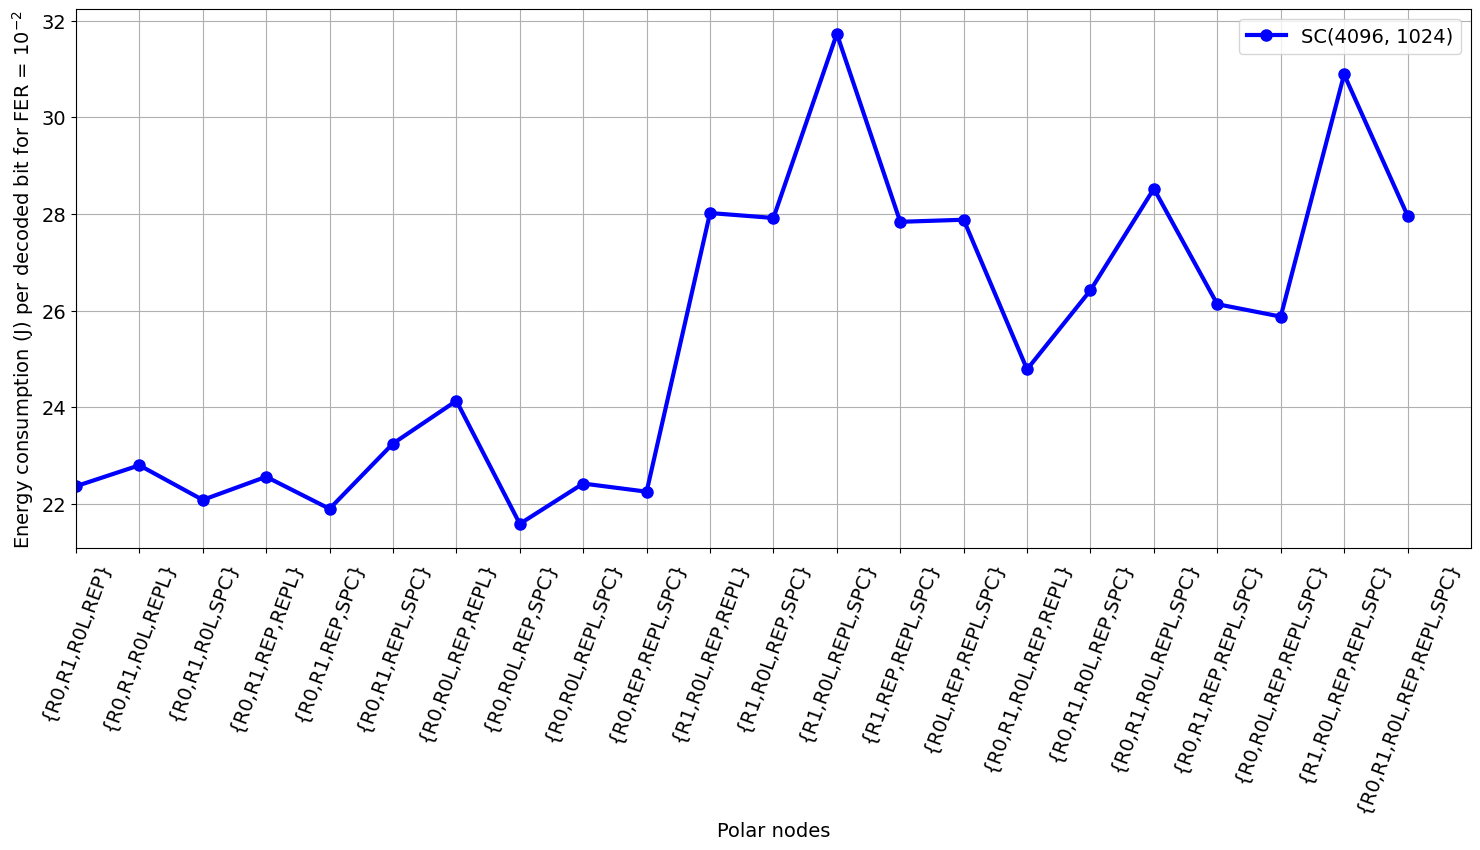

In [ ]:
width = 18
height = 7 
ms = 8
lw = 3
label_size = 14
ind_start =  0 # 6 for 2 nodes activates # 21 for 3 # 41 for 4 # 56 for 5
ind_lim = power_cons_SC_order.shape[0]

fig_name = "Energy_cons_polar_nodes" + str(N) + "_" + str(K) + "_CRC_" + CRC

fig_pw, (ax_pw) = plt.subplots(num=fig_name, figsize=(width, height))

# power_cons_SC_order[5] = power_cons_SC_order[5] * 10

# ax_pw.plot(np.arange(ind_start, ind_lim), power_cons_SC_order[ind_start:ind_lim], ms=ms, linewidth=lw, marker='o', color='brown')
ax_pw.plot(np.arange(ind_start, ind_lim), power_cons_SC_2_order[ind_start:ind_lim], ms=ms, linewidth=lw, marker='o', color='blue')
# ax_pw.plot(np.arange(ind_start, ind_lim), power_cons_SCL_order[ind_start:ind_lim], ms=ms, linewidth=lw, marker='o', color='green')
# ax_pw.plot(np.arange(ind_start, ind_lim), power_cons_SCL_2_order[ind_start:ind_lim], ms=ms, linewidth=lw, marker='o', color='red')
# ax_pw.plot(np.arange(0, power_cons_SCL_MEM_order.shape[0]), power_cons_SCL_MEM_order, ms=ms, linewidth=lw, marker='o', color='blue')
ax_pw.set_xlim((ind_start, ind_lim))
# ax_pw.set_ylim((1e-4, 2))
ax_pw.set_xlabel("Polar nodes", fontsize=label_size)
ax_pw.set_ylabel("Energy consumption (J) per decoded bit for FER = " + "$10^{-2}$", fontsize=label_size)
# ax_pw.set_yscale("log")
ax_pw.grid(True, which='both', axis='both')
ax_pw.tick_params(axis='both', which='major', labelsize=label_size)  
ax_pw.tick_params(axis='both', which='minor', labelsize=label_size-3)
# ax_pw.set_xticklabels(list_order_nodes_ref)
ax_pw.set_xticks(ticks=np.arange(ind_start, ind_lim), labels=list_order_nodes_ref[ind_start:ind_lim], rotation=70)

ax_pw.legend(["SC(4096, 1024)", "SCL-4(4096, 1024)"],loc='upper right', prop={'size': label_size}, ncol=1)
# "SCL-MEM", "ASCL", "ASCL-MEM"
# "SC(32768, 16384)", "SCL-4(4096, 2048)", "SC(4096, 2048)" 

In [19]:
# # Saving fig
# fig_pw.savefig('figures_energy/' + fig_name + '_comp_SCL4_code4096_code32768.eps', format='eps', bbox_inches="tight")
# fig_pw.savefig('figures_energy/' + fig_name + '_comp_SCL4_code4096_code32768.pdf', format="pdf", bbox_inches="tight")
# fig_pw.savefig('figures_energy/' + fig_name + '_comp_SC_SCL4_code32768.eps', format='eps', bbox_inches="tight")
# fig_pw.savefig('figures_energy/' + fig_name + '_comp_SC_SCL4_code32768.pdf', format="pdf", bbox_inches="tight")

# Plotting according to SIMD strategy

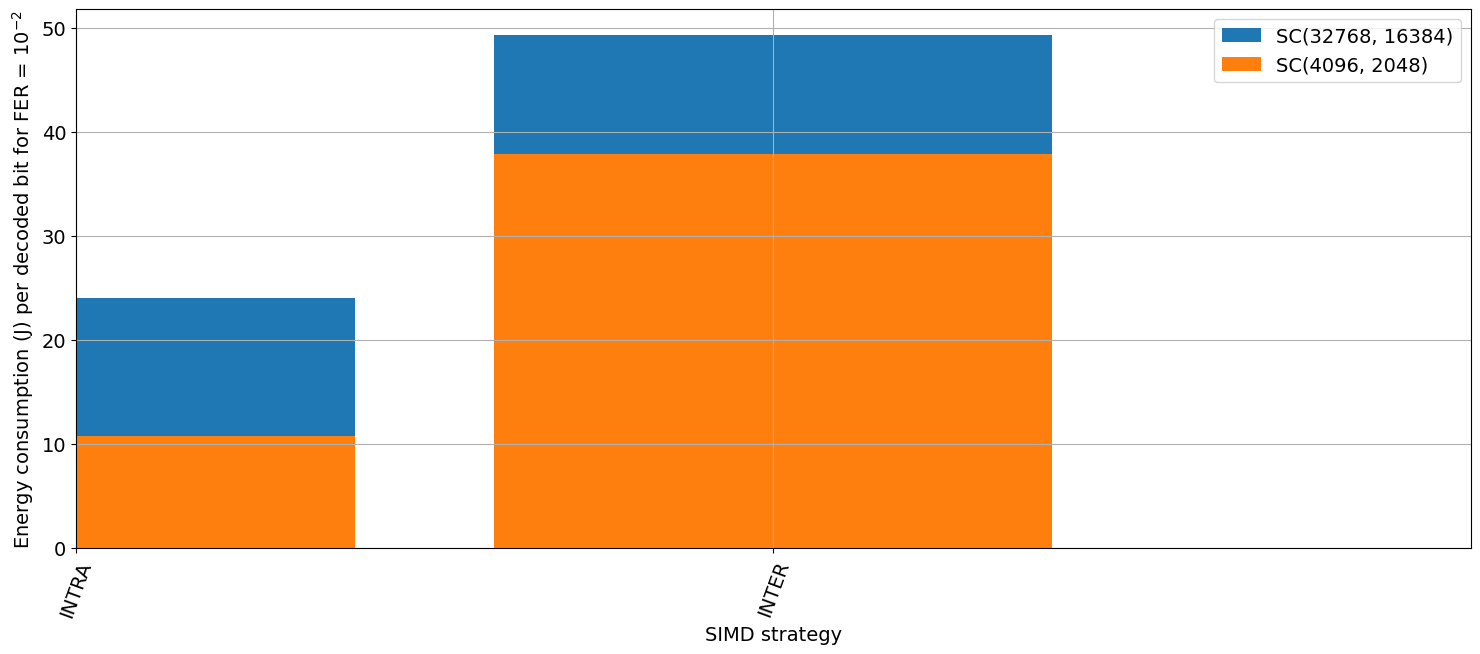

In [20]:
width = 18
height = 7 
ms = 8
lw = 3
label_size = 14

fig_name = "Power_cons_SIMD_" + str(N) + "_" + str(K) + "_CRC_" + CRC

fig_pw2, (ax_pw2) = plt.subplots(num=fig_name, figsize=(width, height))


ax_pw2.bar(np.arange(0, power_cons_SC_2_simd_order.shape[0]), power_cons_SC_2_simd_order)
ax_pw2.bar(np.arange(0, power_cons_SC_simd_order.shape[0]), power_cons_SC_simd_order)
ax_pw2.set_xlim((0, power_cons_SC_simd_order.shape[0]))
# ax_pw.set_ylim((1e-4, 2))
ax_pw2.set_xlabel("SIMD strategy", fontsize=label_size)
ax_pw2.set_ylabel("Energy consumption (J) per decoded bit for FER = " + "$10^{-2}$", fontsize=label_size)
# ax_pw2.set_yscale("log")
ax_pw2.grid(True, which='both', axis='both')
ax_pw2.tick_params(axis='both', which='major', labelsize=label_size)  
ax_pw2.tick_params(axis='both', which='minor', labelsize=label_size-3)
# ax_pw.set_xticklabels(list_order_nodes_ref)
ax_pw2.set_xticks(ticks=np.arange(0, power_cons_SC_simd_order.shape[0]), labels=list_order_simd, rotation=70)

ax_pw2.legend(["SC(32768, 16384)", "SC(4096, 2048)", "SCL-4(4096, 2048)"],loc='upper right', prop={'size': label_size}, ncol=1)
# ax_pw.legend(["SC","SCL", "SCL-MEM", "ASCL", "ASCL-MEM"],loc='upper right', prop={'size': label_size}, ncol=1)
# "SCL-MEM", "ASCL", "ASCL-MEM"

In [21]:
print(2/5 * 4096)

1638.4
